# simple_ann

simple_ann es un programa en Python que construye una red neuronal artificial en Keras https://keras.io/ partir de una lista de péptidos de igual longitud.

Creditos:

Morten Nielsen. (2019, July). ANNs with Keras API. 22125 - Algorithms in Bioinformatics, DTU. https://kurser.dtu.dk/course/22125

# Keras imports

In [1]:
import keras

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.random import set_seed

# Python imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
np.random.seed(7)
set_seed(7)

## Define la ruta hacia el directorio donde estan los datos

In [11]:
train_data = "A0201/f000"
valid_data = "A0201/c000"

## Define las opciones para la corrida

In [6]:
MAX_PEP_SEQ_LEN=9

## Funciones

In [7]:
def read_pep(filename, MAX_PEP_SEQ_LEN):
    '''
    read AA seq of peptides and MHC molecule from text file
    parameters:
        - filename : file in which data is stored
    returns:
        - pep_aa : list of amino acid sequences of peptides (as string)
        - target : list of log transformed IC50 binding values
    '''
    pep_aa = []
    target = []
    infile = open(filename, "r")

    for l in infile:
        l = l.strip().split()
        assert len(l) == 3
        if len(l[0]) <= MAX_PEP_SEQ_LEN:
            pep_aa.append(l[0])
            target.append(l[1])
    infile.close()

    return pep_aa, target

In [8]:
def read_blosum_MN(filename):
    '''
    read in BLOSUM matrix
    parameters:
        - filename : file containing BLOSUM matrix
    returns:
        - blosum : dictionnary AA -> blosum encoding (as list)
    '''

    # read BLOSUM matrix:
    blosumfile = open(filename, "r")
    blosum = {}
    B_idx = 99
    Z_idx = 99
    star_idx = 99

    for l in blosumfile:
        l = l.strip()

        if l[0] != '#':
            l = l.strip().split()

            if (l[0] == 'A') and (B_idx==99):
                B_idx = l.index('B')
                Z_idx = l.index('Z')
                star_idx = l.index('*')
            else:
                aa = str(l[0])
                if (aa != 'B') &  (aa != 'Z') & (aa != '*'):
                    tmp = l[1:len(l)]
                    # tmp = [float(i) for i in tmp]
                    # get rid of BJZ*:
                    tmp2 = []
                    for i in range(0, len(tmp)):
                        if (i != B_idx) &  (i != Z_idx) & (i != star_idx):
                            tmp2.append(float(tmp[i]))

                    #save in BLOSUM matrix
                    blosum[aa] = tmp2
    blosumfile.close()
    return(blosum)


In [14]:
def encode_pep(Xin, max_pep_seq_len):
    '''
    encode AA seq of peptides using BLOSUM50
    parameters:
        - Xin : list of peptide sequences in AA
    returns:
        - Xout : encoded peptide seuqneces (batch_size, max_pep_seq_len, n_features)
    '''
    # read encoding matrix:
    blosum = read_blosum_MN('A0201/BLOSUM50')
    n_features = len(blosum['A'])
    n_seqs = len(Xin)

    # make variable to store output:
    Xout = np.zeros((n_seqs, max_pep_seq_len, n_features),
                       dtype=np.uint8)

    for i in range(0, len(Xin)):
        for j in range(0, len(Xin[i])):
            Xout[i, j, :n_features] = blosum[ Xin[i][j] ]
    return Xout

# Programa

## Lee los datos

In [15]:
# read in peptide sequences and targets:
X_train_raw, y_train_raw = read_pep(train_data, MAX_PEP_SEQ_LEN)
X_val_raw, y_val_raw = read_pep(valid_data, MAX_PEP_SEQ_LEN)

## Codifica los datos

In [16]:
# encode data using BLOSUM50:
X_train = encode_pep(X_train_raw, MAX_PEP_SEQ_LEN)
y_train = np.array(y_train_raw).astype(np.float64)
X_val = encode_pep(X_val_raw, MAX_PEP_SEQ_LEN)
y_val = np.array(y_val_raw).astype(np.float64)

In [17]:
# data dimensions now:
# (N_SEQS, SEQ_LENGTH, N_FEATURES)
print(X_train.shape)
print(X_val.shape)

n_features = X_train.shape[2]

(2471, 9, 21)
(618, 9, 21)


In [18]:
# Reshape data
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

In [19]:
print(X_train.shape)
print(X_val.shape)

(2471, 189)
(618, 189)


## Compila el modelo

In [36]:
# create model
initializer = keras.initializers.RandomNormal(seed=7)

model = Sequential()
model.add(Dense(100, input_dim=MAX_PEP_SEQ_LEN * n_features, activation='relu', kernel_initializer=initializer))
model.add(Dense(80, activation='relu', kernel_initializer=initializer))
model.add(keras.layers.Dropout(.5))
model.add(Dense(1))

# Compile model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               19000     
                                                                 
 dense_8 (Dense)             (None, 80)                8080      
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 81        
                                                                 
Total params: 27,161
Trainable params: 27,161
Non-trainable params: 0
_________________________________________________________________


## Ajusta o entrena el modelo

In [38]:
EPOCHS = 40
MINI_BATCH_SIZE = 10

In [39]:
# Fit the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=MINI_BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/40
248/248 [==============================] - 1s 2ms/step - loss: 115.8883 - mean_squared_error: 115.8883 - val_loss: 0.2433 - val_mean_squared_error: 0.2433
Epoch 2/40
248/248 [==============================] - 0s 2ms/step - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.1471 - val_mean_squared_error: 0.1471
Epoch 3/40
248/248 [==============================] - 0s 2ms/step - loss: 0.1571 - mean_squared_error: 0.1571 - val_loss: 0.1212 - val_mean_squared_error: 0.1212
Epoch 4/40
248/248 [==============================] - 0s 2ms/step - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 5/40
248/248 [==============================] - 0s 2ms/step - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 6/40
248/248 [==============================] - 0s 2ms/step - loss: 0.1128 - mean_squared_error: 0.1128 - val_loss: 0.0948 - val_mean_squared_error: 0.0948
Epoch 7/40
248/248 [====

## Métricas de entrenamiento

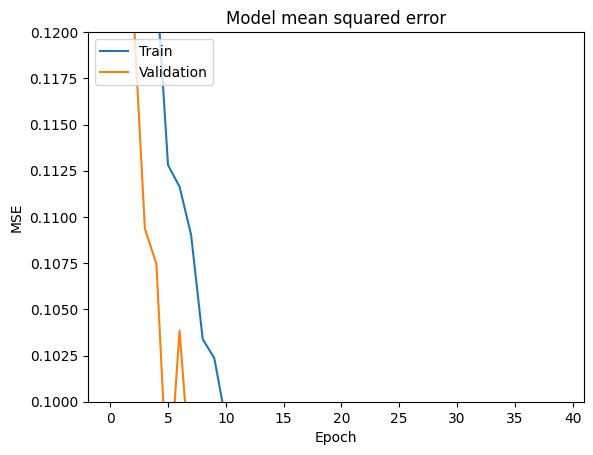

Lowest MSE value: 0.24326813220977783


In [40]:
# Plot training & validation MSE values
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model mean squared error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.ylim(0.1, 0.12)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
print('Lowest MSE value:', np.max(history.history['val_mean_squared_error']))

## Evalúa el modelo

In [32]:
# evaluate the model
scores = model.evaluate(X_val, y_val)
print("\n%s: %.4f" % (model.metrics_names[1], scores[1]))

20/20 [==============================] - 0s 1ms/step - loss: 0.0908 - mean_squared_error: 0.0908

mean_squared_error: 0.0908
